In [1]:
# WESL imports
from utils.path_tools import get_data_path


# WESL Optimizer Dependencies
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
plt.ioff()
from scipy.interpolate import griddata
from pyproj import Transformer
import openmdao.api as om
from scipy.spatial.distance import pdist, squareform
from matplotlib.path import Path
from matplotlib.patches import Circle
from IPython.display import display

# AEP Calculator: PyWake Dependencies
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.site._site import UniformWeibullSite
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine

# Electrical layout (Alencar's (DTU) MSc Thesis heuristic Model)
from interarray.interface import heuristic_wrapper
from interarray.farmrepo import g,g1

In [2]:
import xarray as xr
from utils.path_tools import get_data_path

# Open the NetCDF water depth dataset
ds = xr.open_dataset(get_data_path("test2.nc"))

# Extract elevation, longitude, and latitude
elevation = ds.elevation
lon = ds.lon
lat = ds.lat

In [3]:
# Vineyard Wind turbine coordinates (lat and long) in degrees
x_coordinates = np.array([ -70.46480443069069, -70.44211908841751, -70.44211908841751,
    -70.41943374614488, -70.39800870066537, -70.46354413389761,
    -70.41880359774835, -70.3973785522688,  -70.3746932099962,
    -70.37532335839221, -70.46354413389761, -70.44085879162498,
    -70.41880359774835, -70.39674840387228, -70.3746932099962,
    -70.46228383710448, -70.44148894002149, -70.41817344935181,
    -70.39674840387228, -70.39611825547571, -70.41628300416268,
    -70.48622947617021, -70.48559932777368, -70.46354413389761,
    -70.44085879162498, -70.44022864322841, -70.43959849483187,
    -70.41691315255923, -70.43833819803878, -70.4389683464353,
    -70.48559932777368, -70.48433903098109, -70.46291398550102,
    -70.48433903098109, -70.46291398550102, -70.48433903098109,
    -70.46165368870794, -70.48370888258455, -70.46291398550102,
    -70.48307873418798, -70.46165368870794, -70.46102354031193,
    -70.50828467004682, -70.50765452165027, -70.50639422485719,
    -70.50639422485719, -70.50639422485719, -70.50513392806405,
    -70.50576407646062, -70.5290795671298,  -70.5290795671298,
    -70.5290795671298,  -70.5290795671298,  -70.52718912194068,
    -70.55113476100642, -70.55113476100642, -70.55050461260986,
    -70.55050461260986, -70.57192965808936, -70.57192965808936,
    -70.57129950969284, -70.59335470356946])

y_coordinates = np.array([41.13771377705393, 41.12205063563724, 41.10448448520549,
     41.087863530517666,41.08833847329956, 41.12062652827484,
     41.07123837043275, 41.07123837043275, 41.07171343336421,
     41.0565097169777,  41.10400965915031, 41.087863530517666,
     41.05555936799715, 41.055084188358165,41.03940133472503,
     41.087388584302744,41.07123837043275, 41.03654950521948,
     41.03797543541734, 41.020862234409464,41.00469568286513,
     41.10448448520549,41.08643868157486, 41.07076330406855,
     41.055084188358165,41.037500128783535,41.02181308448496,
     41.020386804223534,41.004220136000555,40.98757383390051,
     41.070288234271686,41.052708238676985,41.053658628846705,
     41.03654950521948,41.03654950521948,41.01991137060574,
     41.020862234409464,41.00279347481808,41.003269031977425,
     40.98757383390051,40.9880495008658, 40.96997174404672,
     41.10305999673841,41.08596372506105,41.069813161042106,
     41.05318343547802,41.03654950521948,41.018485049161285,
     41.003269031977425,41.08691363465488,41.07076330406855,
     41.055084188358165,41.03702481871761,41.01943593355608,
     41.069338084379865,41.052708238676985,41.03512354413252,
     41.01943593355608,41.052708238676985,41.03559886792698,
     41.01896049307459,41.03464821690599])

# Converts lat/long from degrees to utm at Vineyard Wind area
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32619", always_xy=True)
x_coordinates, y_coordinates = transformer.transform(x_coordinates, y_coordinates)


In [4]:
# Define a range for the water depth map
min_lon = -70.8
max_lon = -70.2
min_lat = 40.7
max_lat = 41.3

# Select a subset of the data for the water depth interpolation map 
subset_ds = ds.sel(lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat))
subset_elevation = subset_ds.elevation
subset_lon = subset_ds.lon
subset_lat = subset_ds.lat

# convert subsets from degrees to utm
subset_lon, subset_lat = transformer.transform(subset_lon, subset_lat)

# Create a much finer grid for interpolation
num_points = 500
lon_fine = np.linspace(subset_lon.min(), subset_lon.max(), num_points)
lat_fine = np.linspace(subset_lat.min(), subset_lat.max(), num_points)
lon_grid_fine, lat_grid_fine = np.meshgrid(lon_fine, lat_fine)

# Prepare data for interpolation by creating a meshgrid from the subsetted 1D coordinates
lon_grid, lat_grid = np.meshgrid(subset_lon, subset_lat)
points = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))
values = subset_elevation.values.ravel()

# Interpolate the data onto the fine grid
interpolated_elevation = griddata(points, 
                                  values, 
                                  (lon_grid_fine, lat_grid_fine), 
                                  method='cubic')

# Conversion again from degrees to utm
min_lon, min_lat = transformer.transform(min_lon, min_lat)
max_lon, max_lat = transformer.transform(max_lon, max_lat)
##########################################################################################




In [5]:
boundary = np.array([[-70.479677,  41.138551],
    [-70.479558,  41.133073],
    [-70.486831,  41.133163],
    [-70.48695 ,  41.127684],
    [-70.5009  ,  41.127505],
    [-70.501019,  41.116547],
    [-70.51497 ,  41.116367],
    [-70.51485 ,  41.105587],
    [-70.528984,  41.105265],
    [-70.528579,  41.094605],
    [-70.54313 ,  41.094605],
    [-70.542725,  41.083639],
    [-70.557276,  41.083639],
    [-70.556871,  41.072671],
    [-70.571422,  41.072518],
    [-70.57122 ,  41.061548],
    [-70.58513 ,  41.061578],
    [-70.58513 ,  41.050385],
    [-70.599231,  41.050385],
    [-70.59886 ,  41.039469],
    [-70.613333,  41.039469],
    [-70.613333,  41.028832],
    [-70.627064,  41.028552],
    [-70.626322,  41.006992],
    [-70.584387,  41.007552],
    [-70.584016,  40.996349],
    [-70.540597,  40.99719 ],
    [-70.540226,  40.97562 ],
    [-70.512394,  40.97562 ],
    [-70.511711,  40.965184],
    [-70.49749 ,  40.965184],
    [-70.496956,  40.943704],
    [-70.468336,  40.944107],
    [-70.468692,  40.954848],
    [-70.454471,  40.95525 ],
    [-70.454471,  40.965721],
    [-70.440249,  40.966258],
    [-70.440427,  40.976861],
    [-70.426481,  40.977054],
    [-70.426481,  40.987957],
    [-70.412359,  40.987957],
    [-70.412359,  40.998616],
    [-70.398559,  40.998858],
    [-70.398238,  41.009757],
    [-70.384116,  41.010241],
    [-70.384746,  41.020623],
    [-70.377459,  41.020978],
    [-70.377459,  41.025944],
    [-70.370172,  41.026298],
    [-70.371821,  41.096771],
    [-70.428547,  41.096147],
    [-70.429789,  41.139194],
    [-70.4797  ,  41.13857 ]])

boundary[:, 0], boundary[:, 1] = transformer.transform(boundary[:, 0], boundary[:, 1])

##########################################################################################



In [6]:
class SG_14222(GenericWindTurbine):
    def __init__(self):
        GenericWindTurbine.__init__(self, name='SG 14.0-222DD', diameter=222, hub_height=150, 
                                    power_norm=14000, turbulence_intensity=0.07)

# Site definition using PyWake and Global Wind Atlas
class VineyardWind(UniformWeibullSite): # Double-check: plot the wind rose
    def __init__(self, ti=0.07, shear=None):
        f = [6.4633, 7.6414, 6.3740, 5.9969, 4.7711, 4.5698, 
             7.3598, 11.8051, 13.2464, 11.0975, 11.1503, 9.5244]
        a = [10.19, 10.45, 9.47, 9.02, 9.48, 9.66, 
             11.44, 13.27, 12.46, 11.36, 12.39, 10.45]
        k = [2.170, 1.725, 1.713, 1.682, 1.521, 1.479,
             1.666, 2.143, 2.385, 2.146, 2.432, 2.373]
        UniformWeibullSite.__init__(self, np.array(f) / np.sum(f), a, k, ti=ti, shear=shear)
        self.name = "Vineyard Wind Farm"

# PyWake setup for AEP computations
wind_turbines = SG_14222() # wind turbine object
site = VineyardWind() # site object
sim_res = Bastankhah_PorteAgel_2014(site, wind_turbines, k=0.0324555)
aep_init = sim_res(x_coordinates, y_coordinates).aep().sum() #AEP



In [7]:
class FixedBottomWindFarm(om.ExplicitComponent):
    """
    Fixed-Bottom Wind Farm System
    """
    def setup(self):

        # X-Layout Coordinates
        self.add_input('x', np.zeros(len(x_coordinates)))


        # Y-Layout Coordinates
        self.add_input('y', np.zeros(len(y_coordinates)))
        
        # Annual Energy Production
        self.add_output('AEP', val=0.0)

    def setup_partials(self):
        
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        x = inputs['x']
        y = inputs['y']

        outputs['AEP'] = -sim_res(x, y).aep().sum()

        # print(outputs['AEP'])
        

In [8]:
class OffshoreSystemPlot(om.ExplicitComponent):
    """
    Plot component for an offshore systems
    """

    def initialize(self):
        self.options.declare('boundary', types=np.ndarray)
        self.options.declare('spacing_diameter', default=6*222, types=(float, int)) # upgrade here for the spacing

    def setup(self):
        n = len(x_coordinates)  # global or pass via options
        self.add_input('x', np.zeros(n))
        self.add_input('y', np.zeros(n))
        self.add_input('AEP', val=0.0)

        self.iteration = 0
        self.circles = []
        self.turbine_scatter = None  
        self.cableA = None
        self.cableB = None


        # Beginning of the plot definition
        self.fig, self.ax = plt.subplots()
        # plt.close(self.fig)
        
        # Defines the water depth map
        plt.pcolormesh(lon_grid_fine, 
                    lat_grid_fine, 
                    interpolated_elevation, 
                    cmap='Blues_r', 
                    shading='auto', 
                    vmin=-50, 
                    vmax=-20)

        plt.colorbar(label="Water Depth (m)")
        plt.plot(boundary[:, 0], 
                 boundary[:, 1], 
                 label='Boundary', 
                 c='black', 
                 linestyle = '--')
        plt.tight_layout()
        # plt.ion()
        self.ax.scatter(x_coordinates,
                        y_coordinates, 
                        c='orange', 
                        marker = '.', 
                        s=8, 
                        label='Initial Layout')
        self.text_box = self.ax.text(0.01, 
                                     0.99, 
                                     '', 
                                     transform=self.ax.transAxes, 
                                     verticalalignment='top', 
                                     fontsize=10, 
                                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        self.ax.set_xlabel('X [m]')
        self.ax.set_ylabel('Y [m]')
        self.ax.set_xlim(360000, 390000)
        self.ax.set_ylim(4.53E6, 4.56E6)

    def compute(self, inputs, outputs):
        x = inputs['x']
        y = inputs['y']
        # aep = float(inputs['AEP'])
        # aep = float(inputs['AEP'][()])  # extract the scalar
        # or
        aep = inputs['AEP'].item()



        spacing_radius = self.options['spacing_diameter'] / 2

        # Remove previous turbine positions (except for the initial layout)
        if self.turbine_scatter is not None:
            self.turbine_scatter.remove()

        if self.cableA is not None:
            for line in self.cableA:
                line.remove()
            self.cableA = None

        if self.cableB is not None:
            for line in self.cableB:
                line.remove()
            self.cableB = None

        # Remove old circles
        for circ in self.circles:
            circ.remove()
        self.circles.clear()

        self.turbine_scatter = self.ax.scatter(x,
                                               y,
                                               marker = '2', 
                                               c='black', 
                                               label='Current Design')

        # Draw new spacing circles
        for xi, yi in zip(x, y):
            circ = Circle((xi, yi), spacing_radius, edgecolor='gray',
                          linestyle='--', facecolor='none', linewidth=1)
            self.ax.add_patch(circ)
            self.circles.append(circ)

        # Draw electrical layout
        VertexC = g1(x,y,boundary).horns.graph['VertexC']
    
        M = g1(x,y,boundary).horns.graph['M']

        X, Y = np.hstack((VertexC[-1:-1 - M:-1].T, VertexC[:-M].T))
        
        Cables = [(-1, 2, 1000), (-1, 4, 1500)]
        
        cable_length = []

        T = heuristic_wrapper(X, Y,Cables,M,heuristic='CPEW')

        T = np.array([[x[0],x[1],x[2],x[3],x[4],Cables[x[4]][2]*x[2]/1000] for x in T])


        for i in range(len(T)):
            # print('cable in meters',T[i][2])
            cable_length.append(T[i][2])

        cable_length = np.array(cable_length).sum()

        Cables = [(-1, 2, 1000), (-1, 4, 1500)]

        ##########################################
        cab0,cab1,cost = [],[],[]

        for i in range(62):
            if T[i][4] == 0.0:
                cab0.append(i)
                cost.append(Cables[0][2]*T[i][2])
            else:
                cab1.append(i)
                cost.append(Cables[1][2]*T[i][2])

        ##########################################
        total_cable_cost = np.array(cost).sum()

        WTcoords = np.array([x,y])

        WTcentroid = np.array([WTcoords[0].mean(), WTcoords[1].mean()]) #UPDATE THIS TO MATCH REAL
        
        total_cable_cost =  round(total_cable_cost*0.000001, 3) 
        
        # plt.scatter(WTcentroid[0],WTcentroid[1],label='Substation',c='red')
        self.ax.scatter(WTcentroid[0],WTcentroid[1],label='Substation',c='red')

        # colors = ['b','g','r','c','m','y','k','bg','gr','rc','cm']
        colors = ['y', '#b87333' ]

        b = T

        Cables = np.array(Cables)

        for i in range(Cables.shape[0]):
            index = b[:,4]==i
            if index.any():
                n1xs = X[b[index,0].astype(int)-1]
                n2xs = X[b[index,1].astype(int)-1]
                n1ys = Y[b[index,0].astype(int)-1]
                n2ys = Y[b[index,1].astype(int)-1]
                xs = np.vstack([n1xs,n2xs])
                ys = np.vstack([n1ys,n2ys])

                if i == 0:
                    self.cableA = self.ax.plot(xs,ys,'{}'.format(colors[i]),linewidth=1.2)
                
                elif i == 1:
                    self.cableB = self.ax.plot(xs,ys,'{}'.format(colors[i]),linewidth=1.2)

        # Update iteration info
        self.text_box.set_text(
            f"Iteration: {self.iteration}\nAEP Improvement: {((-aep / aep_init) - 1) * 100:.3f} %"
        )
        # plt.show()

        plt.draw()
        plt.pause(0.001) 
        # self.ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, fontsize=10)
        # Rebuild legend without duplicates
        handles, labels = self.ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))  # removes duplicates based on label
        self.ax.legend(by_label.values(), by_label.keys(),
                    loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, fontsize=10)


        # self.plot_electrical_layout = plot_electrical_cables1(x,y,iter=1)

        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

        self.iteration += 1


In [9]:
class PairWiseSpacing(om.ExplicitComponent):
    """
    Pair-Wise Spacing Constraint Component
    """
    def setup(self):

        # X-Layout Coordinates
        self.add_input('x', np.zeros(len(x_coordinates)))

        # Y-Layout Coordinates
        self.add_input('y', np.zeros(len(y_coordinates)))
        
        self.add_output('Spacing_Matrix', np.zeros(len(x_coordinates)*len(x_coordinates)-len(x_coordinates)))

    def setup_partials(self):
        
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        x = inputs['x']
        y = inputs['y']

        points = np.column_stack((x, y))  

        dist_matrix = squareform(pdist(points))

        flat_dist_matrix = dist_matrix.reshape(-1)
        nonzero_values = flat_dist_matrix[flat_dist_matrix != 0]

        d_min = 6*222

        # if np.any(nonzero_values < d_min):
        #     print("Some values below the minimum were found.")
        # else:
        #     print("All nonzero values are above the minimum.")

        # min_spac = min(nonzero_values)/80

        # print(f"Minimum Spacing is {min_spac:.2f}D")

        outputs['Spacing_Matrix'] = nonzero_values


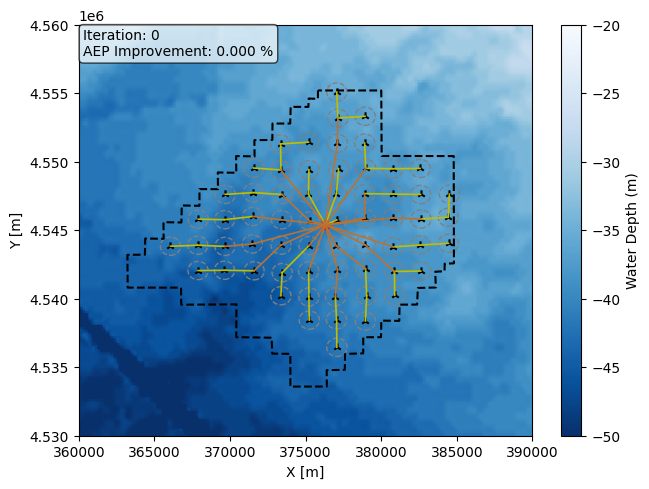

<Figure size 640x480 with 0 Axes>

/opt/anaconda3/envs/test_sept23rd_D/lib/python3.12/site-packages/scipy/_lib/pyprima/common/preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 126
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Optimization FAILED.
Return from COBYLA because the objective function has been evaluated MAXFUN times.
-----------------------------------


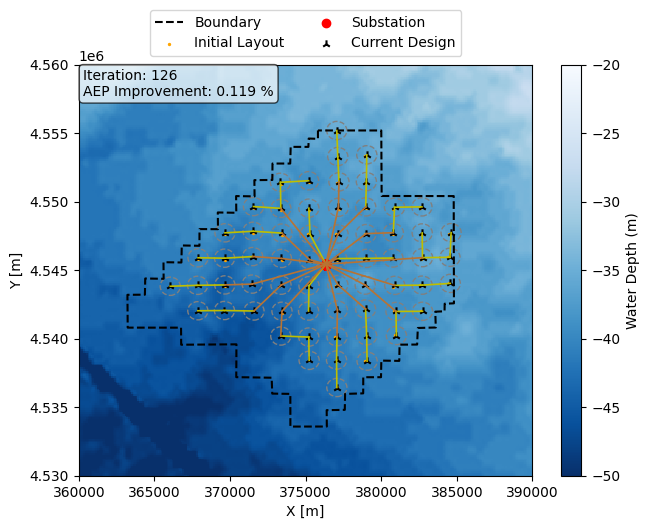

In [10]:
prob = om.Problem()

prob.model.add_subsystem('FBWF', 
                         FixedBottomWindFarm(), 
                         promotes_inputs=['x', 'y'])

prob.model.add_subsystem('Spacing_Constraint', 
                         PairWiseSpacing(), 
                         promotes_inputs=['x', 'y'])

prob.model.add_subsystem('OffshoreSystemPlot',
                         OffshoreSystemPlot(boundary=boundary),
                         promotes_inputs=['x', 'y']
)

prob.model.connect('FBWF.AEP', 'OffshoreSystemPlot.AEP')

prob.driver = om.ScipyOptimizeDriver(tol = 1e-9)

prob.driver.options['optimizer'] = 'COBYLA'
prob.driver.options['maxiter'] = 10

prob.driver.options['disp'] = True

prob.model.set_input_defaults('x', x_coordinates)
prob.model.set_input_defaults('y', y_coordinates)
prob.model.add_design_var('x', lower=min(boundary[:,0]), upper=max(boundary[:,0]), scaler=0.01)
prob.model.add_design_var('y', lower=min(boundary[:,1]), upper=max(boundary[:,1]), scaler=0.01)
prob.model.add_objective('FBWF.AEP',  scaler=0.01)
prob.model.add_constraint('Spacing_Constraint.Spacing_Matrix', scaler=0.01)
prob.driver.options['disp'] = False
prob.setup()

prob.run_driver()
display(prob.model.OffshoreSystemPlot.fig)


